In [ ]:
#之前的作业里面输出结果错误，没有输出房子价格租金之比，在此修正

In [6]:
import pandas as pd
import os


# 读取文件
excel_file = pd.ExcelFile('total_data.xlsx')

# 处理房价情况工作表
df_price = excel_file.parse('房价情况')
# 计算 unit * square - total
df_price['calc_value'] = df_price['unit'] * df_price['square'] - df_price['total']

# 处理房租情况工作表
df_rent = excel_file.parse('房租情况')
# 计算 rent / square
df_rent['rent_per_square'] = df_rent['rent'] / df_rent['square']


# 定义函数用于查找异常值并标注
def find_outliers(df, columns, group_column=None):
    all_outliers = []
    if group_column:
        for group in df[group_column].unique():
            subset = df[df[group_column] == group]
            for col in columns:
                if col == 'calc_value':
                    outliers = subset[subset[col].abs() > 500].copy()
                    outliers['异常类型'] = '异常值'
                    outliers['异常值所在列'] = col
                    outliers['异常值判断标准'] = '绝对值大于500'
                else:
                    mean_value = subset[col].mean()
                    std_value = subset[col].std()
                    lower_bound = mean_value - 3 * std_value
                    upper_bound = mean_value + 3 * std_value
                    outliers = subset[(subset[col] < lower_bound) | (subset[col] > upper_bound)].copy()
                    outliers['异常类型'] = '异常值'
                    outliers['异常值所在列'] = col
                    outliers['异常值判断标准'] = f'均值={mean_value}, 标准差={std_value}, 下限={lower_bound}, 上限={upper_bound}'
                all_outliers.append(outliers)
    else:
        for col in columns:
            if col == 'calc_value':
                outliers = df[df[col].abs() > 500].copy()
                outliers['异常类型'] = '异常值'
                outliers['异常值所在列'] = col
                outliers['异常值判断标准'] = '绝对值大于500'
            else:
                mean_value = df[col].mean()
                std_value = df[col].std()
                lower_bound = mean_value - 3 * std_value
                upper_bound = mean_value + 3 * std_value
                outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].copy()
                outliers['异常类型'] = '异常值'
                outliers['异常值所在列'] = col
                outliers['异常值判断标准'] = f'均值={mean_value}, 标准差={std_value}, 下限={lower_bound}, 上限={upper_bound}'
            all_outliers.append(outliers)

    if all_outliers:
        return pd.concat(all_outliers)
    else:
        return pd.DataFrame()


# 查找房价情况表的异常值
outliers_price = find_outliers(df_price, ['calc_value', 'unit'], group_column='location')

# 查找房租情况表的异常值
outliers_rent = find_outliers(df_rent, ['rent_per_square'], group_column='location')

# 合并不同工作表的异常值
all_outliers = pd.concat([outliers_price, outliers_rent])

# 创建保存文件夹
output_folder = 'outliers_output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 将结果保存为 CSV 文件
all_outliers.to_csv(os.path.join(output_folder, 'outliers.csv'), index=False)

房价表中删除了 1 行calc_value=-1210024.0的数据
房租表中删除了 5 行rent=800000的数据
统计结果已保存到 housing_analysis_results 文件夹


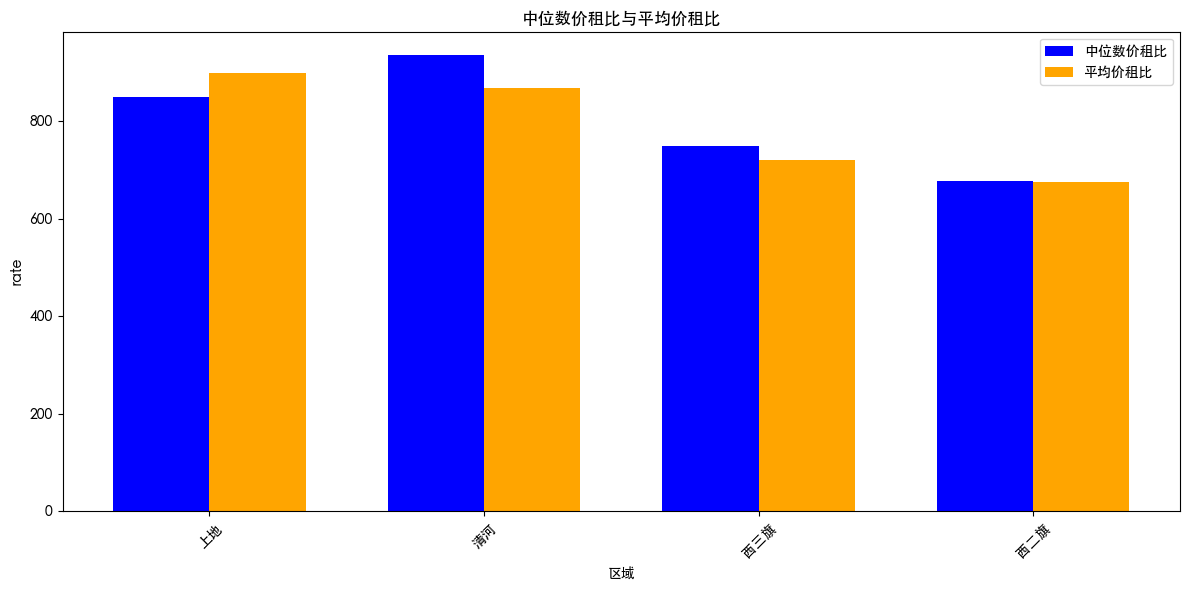

In [27]:
# 根据标准差法检测的最终结果，发现有57个异常值
# 其中有51组的数据接近正常分布情况
# 剩余6组一组可能是未知原因导致的房价信息爬取错误导致的总价和单价有出入
# 剩余5组经查询发现是装修广告，决定将这6组删去。
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# 设置中文字体，确保中文正常显示
plt.rcParams["font.family"] = [ "Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

def process_housing_data(excel_file_path):
    """
    处理房屋数据，执行清洗、计算和可视化操作
    """
    # 创建输出文件夹
    output_dir = "housing_analysis_results"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 读取Excel文件
    try:
        excel_data = pd.ExcelFile(excel_file_path)
    except Exception as e:
        print(f"读取文件出错: {e}")
        return
    
    # 读取房价情况表
    try:
        df_price = excel_data.parse('房价情况')
        # 确保calc_value列存在
        if 'calc_value' not in df_price.columns:
            df_price['calc_value'] = df_price['unit'] * df_price['square'] - df_price['total']
        
        # 数据清洗：删除calc_value=-1210024.0的行
        initial_count = len(df_price)
        df_price = df_price[df_price['calc_value'] != -1210024.0]
        removed_count = initial_count - len(df_price)
        print(f"房价表中删除了 {removed_count} 行calc_value=-1210024.0的数据")
    except Exception as e:
        print(f"处理房价表出错: {e}")
        return
    
    # 读取房租情况表
    try:
        df_rent = excel_data.parse('房租情况')
        # 确保rent_per_square列存在
        if 'rent_per_square' not in df_rent.columns:
            df_rent['rent_per_square'] = df_rent['rent'] / df_rent['square']
        
        # 数据清洗：删除rent=800000的行
        initial_count = len(df_rent)
        df_rent = df_rent[df_rent['rent'] != 800000]
        removed_count = initial_count - len(df_rent)
        print(f"房租表中删除了 {removed_count} 行rent=800000的数据")
    except Exception as e:
        print(f"处理房租表出错: {e}")
        return
    
    # 计算不同location的统计指标
    try:
        # 房价相关计算
        price_stats = df_price.groupby('location').agg(
            平均每平方米房价=('total', lambda x: x.sum() / df_price.loc[x.index, 'square'].sum()),
            unit中位数=('unit', 'median')
        ).reset_index()
        
        # 租金相关计算
        rent_stats = df_rent.groupby('location').agg(
            平均每平方米租金=('rent', lambda x: x.sum() / df_rent.loc[x.index, 'square'].sum()),
            rent_per_square中位数=('rent_per_square', 'median')
        ).reset_index()
        
        # 保存统计结果
        price_stats.to_csv(os.path.join(output_dir, '房价统计结果.csv'), index=False)
        rent_stats.to_csv(os.path.join(output_dir, '租金统计结果.csv'), index=False)
        print(f"统计结果已保存到 {output_dir} 文件夹")
    except Exception as e:
        print(f"计算统计指标出错: {e}")
        return
    
    # 绘制条形图
    try:
        # 1. 各区域的unit中位数和平均每平方米房价条形图
        plt.figure(figsize=(12, 6))
        bar_width = 0.35
        index = np.arange(len(price_stats['location']))
        
        plt.bar(index, price_stats['unit中位数']/rent_stats['rent_per_square中位数'], bar_width, label='中位数价租比', color='blue')
        plt.bar(index + bar_width, price_stats['平均每平方米房价']/ rent_stats['平均每平方米租金'], bar_width, label='平均价租比', color='orange')
        
        plt.xlabel('区域')
        plt.ylabel('rate')
        plt.title('中位数价租比与平均价租比')
        plt.xticks(index + bar_width / 2, price_stats['location'], rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, '中位数价租比与平均价租比.png'), dpi=300)
        plt.show()
        plt.close()
    except Exception as e:
        print(f"绘制图表出错: {e}")
        return
        

if __name__ == "__main__":
    # 输入Excel文件路径
    excel_path = "total_data.xlsx"  # 假设文件与脚本在同一目录
    if os.path.exists(excel_path):
        process_housing_data(excel_path)
    else:
        print(f"错误：未找到文件 {excel_path}")
        print("请将Excel文件放在与脚本相同的目录，或修改代码中的文件路径")



In [9]:
import pandas as pd
import statsmodels.api as sm

# 定义 location 到 location_distance 的映射
# location_distance为该地区中心位置到中关村和海淀黄庄的平均加权距离
location_dist_map = {
    '清河': 8.35,
    '上地': 7.1,
    '西二旗': 8.5,
    '西三旗': 13.5
}

# 为 df_price 增添 location_distance 列
df_price['location_distance'] = df_price['location'].map(location_dist_map)

# 为 df_rent 增添 location_distance 列
df_rent['location_distance'] = df_rent['location'].map(location_dist_map)

# -------------------- Model 1: price/m2 = β₀m2 + β₂location + ε --------------------
# 准备自变量和因变量，添加常数项
X1 = df_price[['square', 'location_distance']]
X1 = sm.add_constant(X1)
y1 = df_price['unit']

# 进行 OLS 回归
model1 = sm.OLS(y1, X1).fit()

# 输出 Model 1 的结果，包括 R²
print("Model 1 Results:")
print(model1.summary())

# -------------------- Model 2: rent/m2 = β₀m2 + β₂location + ε --------------------
# 准备自变量和因变量，添加常数项
X2 = df_rent[['square', 'location_distance']]
X2 = sm.add_constant(X2)
y2 = df_rent['rent_per_square']

# 进行 OLS 回归
model2 = sm.OLS(y2, X2).fit()

# 输出 Model 2 的结果，包括 R²
print("\nModel 2 Results:")
print(model2.summary())

Model 1 Results:
                            OLS Regression Results                            
Dep. Variable:                   unit   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     690.3
Date:                Thu, 16 Oct 2025   Prob (F-statistic):          1.04e-260
Time:                        13:04:30   Log-Likelihood:                -49457.
No. Observations:                4304   AIC:                         9.892e+04
Df Residuals:                    4301   BIC:                         9.894e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.

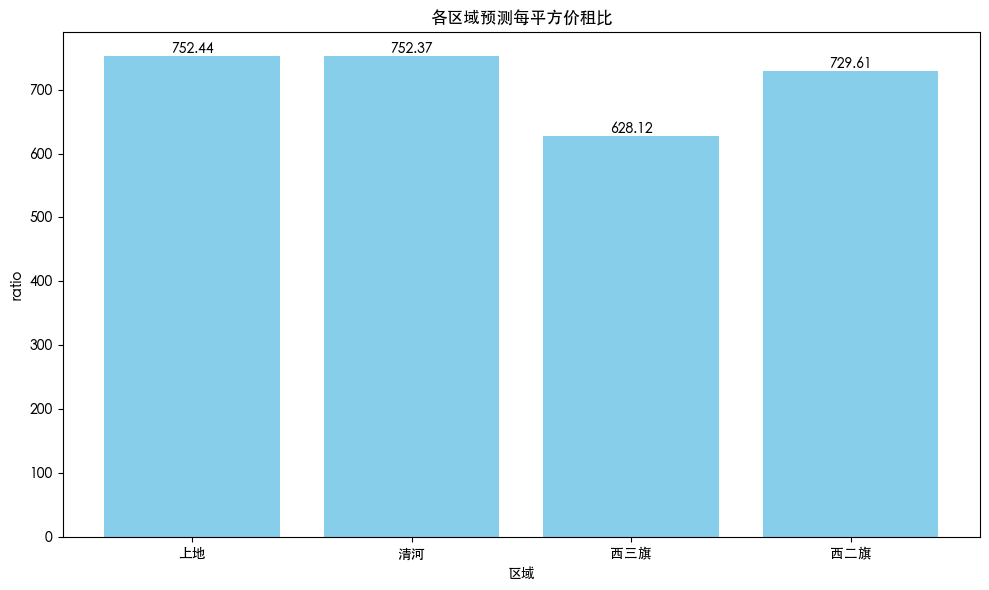

预测结果和图表已保存到 prediction_results 文件夹


In [28]:
# 使用模型1进行预测，得到预测的每平方米房价
df_price['unit_1'] = model1.predict(X1)
# 使用模型2进行预测，得到预测的每平方米租金
df_rent['rent_per_square_1'] = model2.predict(X2)
# -------------------- 计算各区域的预测值中位数 --------------------
# 计算各区域预测每平方米房价的中位数
price_medians = df_price.groupby('location')['unit_1'].median().reset_index()
price_medians.columns = ['location', '预测每平方米房价中位数']

# 计算各区域预测每平方米租金的中位数
rent_medians = df_rent.groupby('location')['rent_per_square_1'].median().reset_index()
rent_medians.columns = ['location', '预测每平方米租金中位数']



# -------------------- 保存条形图到文件夹 --------------------
# 创建输出文件夹
output_dir = "prediction_results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 重新绘制并保存预测每平方米房价中位数条形图
plt.figure(figsize=(10, 6))
bars = plt.bar(price_medians['location'], price_medians['预测每平方米房价中位数']/rent_medians['预测每平方米租金中位数'], color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', rotation=0)

plt.title('各区域预测每平方价租比')
plt.xlabel('区域')
plt.ylabel('ratio')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '各区域预测价租比.png'), dpi=300)
plt.show()
plt.close()



print(f"预测结果和图表已保存到 {output_dir} 文件夹")

In [17]:
# 添加 location_distance 的平方项
df_price['location_distance_sq'] = df_price['location_distance'] ** 2
# 添加 location_distance 与 square 的交互项
df_price['loc_dist_sq_interact'] = df_price['location_distance'] * df_price['square']
# 添加 location_distance 的平方项
df_rent['location_distance_sq'] = df_rent['location_distance'] ** 2
# 添加 location_distance 与 square 的交互项
df_rent['loc_dist_sq_interact'] = df_rent['location_distance'] * df_rent['square']

# -------------------- Model 1: 扩展模型（含平方项和交互项） --------------------
# 模型表达式：price/m2 = β₀ + β₁*m2 + β₂*location + β₃*location² + β₄*(location*m2) + ε
# 准备自变量（包含原变量、平方项和交互项）
X1_p = df_price[['square', 'location_distance', 'location_distance_sq', 'loc_dist_sq_interact']]
X1_p = sm.add_constant(X1_p)  
y1_p = df_price['unit']

# 进行 OLS 回归
model1_p = sm.OLS(y1_p, X1_p).fit()

# 输出 Model 1 的结果，包括 R²
print("=== Model 1_P Results (with squared term and interaction term) ===")
print(model1_p.summary())

# -------------------- Model 2: 扩展模型（含平方项和交互项） --------------------
# 模型表达式：rent/m2 = β₀ + β₁*m2 + β₂*location + β₃*location² + β₄*(location*m2) + ε
# 准备自变量（包含原变量、平方项和交互项）
X2_p = df_rent[['square', 'location_distance', 'location_distance_sq', 'loc_dist_sq_interact']]
X2_p = sm.add_constant(X2_p)  
y2_p = df_rent['rent_per_square']

# 进行 OLS 回归
model2_p = sm.OLS(y2_p, X2_p).fit()

# 输出 Model 2 的结果，包括 R²
print("\n=== Model 2_p Results (with squared term and interaction term) ===")
print(model2_p.summary())


=== Model 1_P Results (with squared term and interaction term) ===
                            OLS Regression Results                            
Dep. Variable:                   unit   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     365.9
Date:                Thu, 16 Oct 2025   Prob (F-statistic):          1.54e-271
Time:                        13:46:28   Log-Likelihood:                -49425.
No. Observations:                4304   AIC:                         9.886e+04
Df Residuals:                    4299   BIC:                         9.889e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [30]:
# 使用模型1进行预测，得到预测的每平方米房价
df_price['unit_2'] = model1_p.predict(X1_p)
# 使用模型2进行预测，得到预测的每平方米租金
df_rent['rent_per_square_2'] = model2_p.predict(X2_p)
# -------------------- 计算各区域的预测值中位数 --------------------
# 计算各区域预测每平方米房价的中位数
price_medians = df_price.groupby('location')['unit_2'].median().reset_index()
price_medians.columns = ['location', '新预测每平方米房价中位数']

# 计算各区域预测每平方米租金的中位数
rent_medians = df_rent.groupby('location')['rent_per_square_2'].median().reset_index()
rent_medians.columns = ['location', '新预测每平方米租金中位数']


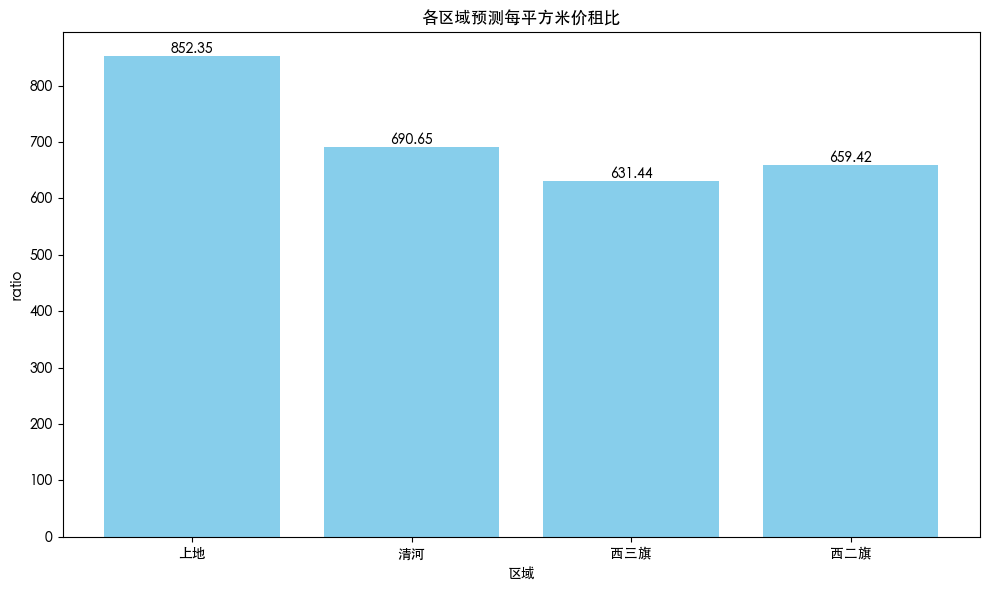

预测结果和图表已保存到 prediction_results_2 文件夹


In [31]:
#绘制并保存预测每平方米房价中位数条形图
output_dir = "prediction_results_2"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

    
plt.figure(figsize=(10, 6))
bars = plt.bar(price_medians['location'], price_medians['新预测每平方米房价中位数']/rent_medians['新预测每平方米租金中位数'], color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', rotation=0)

plt.title('各区域预测每平方米价租比')
plt.xlabel('区域')
plt.ylabel('ratio')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '新预测价租比.png'), dpi=300)
plt.show()
plt.close()


print(f"预测结果和图表已保存到 {output_dir} 文件夹")

In [ ]:
#对比可以发现模型2解释程度更高，且预测效果更接近真实情况